In [22]:
!pip install --quiet scikit-learn torchsummary

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

In [24]:
data_path = 'data_crossval'

data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=data_path, transform=data_transform)

batch_size = 32
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [25]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load the best model
best_model = CNN()
best_model.load_state_dict(torch.load('best_CNN_model.pth', map_location=torch.device('cpu')))
best_model.eval()

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [26]:
true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

In [27]:
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

Test Accuracy: 97.60%
Precision: 0.9818
Recall: 0.9700
F1 Score: 0.9759

Confusion Matrix:
[[982  18]
 [ 30 970]]


T-statistic: 1.7329179169135913, p-value: 0.08326447806058392
Confusion Matrix:
[[982  18]
 [ 30 970]]


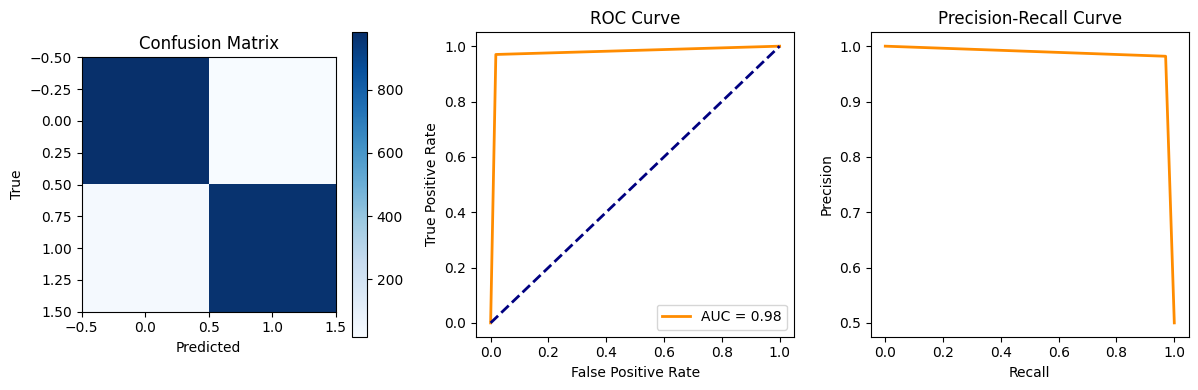

In [28]:
# T-test
t_stat, p_value = ttest_rel(true_labels, predicted_labels)
print(f"T-statistic: {t_stat}, p-value: {p_value}")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# ROC Curve
fpr, tpr, _ = roc_curve(true_labels, predicted_labels)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(true_labels, predicted_labels)

# Plotting
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(conf_matrix, cmap='Blues', interpolation='None')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.subplot(1, 3, 3)
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()